In [14]:
import pandas as pd

# Phase 1 (Lifestyle-only)
X = pd.read_csv(r"..\data\processed\X_features.csv")

# Phase 2 (Lifestyle + Weight)
X_with_weight = pd.read_csv(r"..\data\processed\X_features_with_weight.csv")

# Target
y = pd.read_csv(r"..\data\processed\y_target.csv").squeeze()

print("Phase 1 shape:", X.shape)
print("Phase 2 shape:", X_with_weight.shape)
print("Weight in Phase 1:", "Weight" in X.columns)
print("Weight in Phase 2:", "Weight" in X_with_weight.columns)

Phase 1 shape: (2111, 19)
Phase 2 shape: (2111, 20)
Weight in Phase 1: False
Weight in Phase 2: True


In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
from sklearn.neighbors import KNeighborsClassifier

k_values = range(1, 31)  # 1 to 30

eu_mean_scores = []
eu_std_scores = []

ma_mean_scores = []
ma_std_scores = []

for k in k_values:
    knn_eu = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    knn_ma = KNeighborsClassifier(n_neighbors=k, metric="manhattan")

    eu_scores = cross_val_score(knn_eu, X, y, cv=cv, scoring="accuracy")
    ma_scores = cross_val_score(knn_ma, X, y, cv=cv, scoring="accuracy")

    eu_mean_scores.append(eu_scores.mean())
    eu_std_scores.append(eu_scores.std())

    ma_mean_scores.append(ma_scores.mean())
    ma_std_scores.append(ma_scores.std())


In [17]:
best_k_eu = k_values[int(np.argmax(eu_mean_scores))]
best_k_ma = k_values[int(np.argmax(ma_mean_scores))]

(best_k_eu, best_k_ma)

(1, 1)

In [18]:
best_eu_idx = int(np.argmax(eu_mean_scores))
best_ma_idx = int(np.argmax(ma_mean_scores))

print(f"Best Euclidean K = {best_k_eu} | Accuracy = {eu_mean_scores[best_eu_idx]:.4f} ± {eu_std_scores[best_eu_idx]:.4f}")
print(f"Best Manhattan K = {best_k_ma} | Accuracy = {ma_mean_scores[best_ma_idx]:.4f} ± {ma_std_scores[best_ma_idx]:.4f}")


Best Euclidean K = 1 | Accuracy = 0.8133 ± 0.0180
Best Manhattan K = 1 | Accuracy = 0.8356 ± 0.0159


In [9]:
# --- Stability-aware K selection (Euclidean) ---
best_eu_mean = max(eu_mean_scores)
candidate_idxs_eu = [
    i for i, acc in enumerate(eu_mean_scores)
    if acc >= best_eu_mean - tolerance
]

best_candidate_idx_eu = min(
    candidate_idxs_eu,
    key=lambda i: (eu_std_scores[i], k_values[i])
)

final_k_eu = k_values[best_candidate_idx_eu]
final_mean_eu = eu_mean_scores[best_candidate_idx_eu]
final_std_eu = eu_std_scores[best_candidate_idx_eu]

print("\n[Final Chosen K - Stability Aware (Euclidean)]")
print(f"K={final_k_eu} | mean={final_mean_eu:.4f} ± {final_std_eu:.4f} (within 1% of best mean)")


[Final Chosen K - Stability Aware (Euclidean)]
K=1 | mean=0.8133 ± 0.0180 (within 1% of best mean)


In [22]:
# --- Stability-aware K selection (Manhattan) ---
best_ma_mean = max(ma_mean_scores)

# Within 1% of best mean accuracy
tolerance = 0.01
candidate_idxs = [
    i for i, acc in enumerate(ma_mean_scores)
    if acc >= best_ma_mean - tolerance
]

# Among candidates: choose lowest std; if tie, smaller K
best_candidate_idx = min(
    candidate_idxs,
    key=lambda i: (ma_std_scores[i], k_values[i])
)

final_k = k_values[best_candidate_idx]
final_mean = ma_mean_scores[best_candidate_idx]
final_std = ma_std_scores[best_candidate_idx]

print("\n[Final Chosen K - Stability Aware (Manhattan without weight)]")
print(f"K={final_k} | mean={final_mean:.4f} ± {final_std:.4f} (within 1% of best mean)")


[Final Chosen K - Stability Aware (Manhattan without weight)]
K=3 | mean=0.8304 ± 0.0121 (within 1% of best mean)


In [19]:
ma_mean_scores_w = []
ma_std_scores_w = []

for k in k_values:
    knn_ma = KNeighborsClassifier(n_neighbors=k, metric="manhattan")
    scores = cross_val_score(knn_ma, X_with_weight, y, cv=cv, scoring="accuracy")
    ma_mean_scores_w.append(scores.mean())
    ma_std_scores_w.append(scores.std())


In [21]:
tolerance = 0.01
best_ma_mean_w = max(ma_mean_scores_w)

candidate_idxs_w = [
    i for i, acc in enumerate(ma_mean_scores_w)
    if acc >= best_ma_mean_w - tolerance
]

best_candidate_idx_w = min(
    candidate_idxs_w,
    key=lambda i: (ma_std_scores_w[i], k_values[i])
)

final_k_w = k_values[best_candidate_idx_w]
final_mean_w = ma_mean_scores_w[best_candidate_idx_w]
final_std_w = ma_std_scores_w[best_candidate_idx_w]

print("[Manhattan (with Weight) Final K]")
print(f"K={final_k_w} | mean={final_mean_w:.4f} ± {final_std_w:.4f} (within 1% of best mean)")


[Manhattan (with Weight) Final K]
K=3 | mean=0.8920 ± 0.0062 (within 1% of best mean)


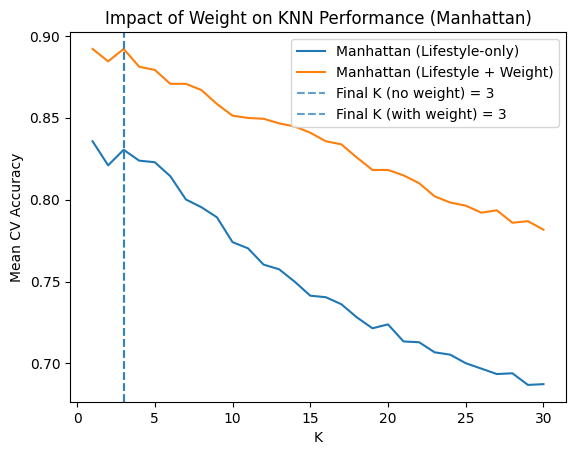

In [23]:
import matplotlib.pyplot as plt

plt.plot(list(k_values), ma_mean_scores, label="Manhattan (Lifestyle-only)")
plt.plot(list(k_values), ma_mean_scores_w, label="Manhattan (Lifestyle + Weight)")

plt.axvline(x=final_k, linestyle="--", alpha=0.7, label=f"Final K (no weight) = {final_k}")
plt.axvline(x=final_k_w, linestyle="--", alpha=0.7, label=f"Final K (with weight) = {final_k_w}")

plt.xlabel("K")
plt.ylabel("Mean CV Accuracy")
plt.title("Impact of Weight on KNN Performance (Manhattan)")
plt.legend()
plt.show()


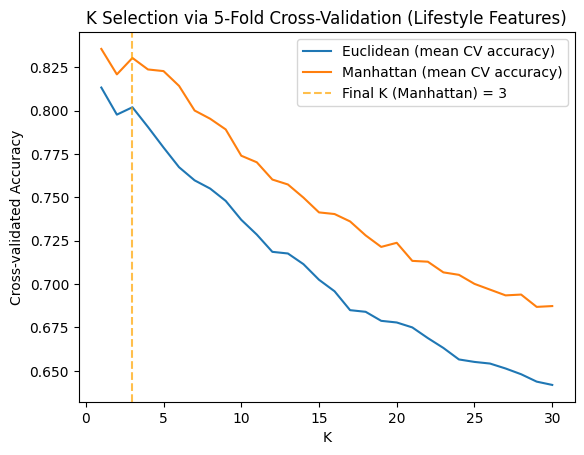

In [11]:
import matplotlib.pyplot as plt

plt.plot(list(k_values), eu_mean_scores, label="Euclidean (mean CV accuracy)")
plt.plot(list(k_values), ma_mean_scores, label="Manhattan (mean CV accuracy)")
plt.xlabel("K")
plt.ylabel("Cross-validated Accuracy")
plt.title("K Selection via 5-Fold Cross-Validation (Lifestyle Features)")
plt.axvline(
    x=final_k,
    color="orange",
    linestyle="--",
    alpha=0.7,
    label=f"Final K (Manhattan) = {final_k}"
)

plt.legend()
plt.show()

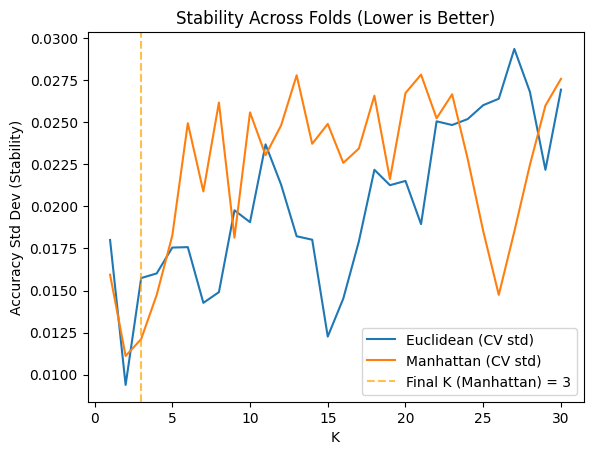

In [12]:
plt.plot(list(k_values), eu_std_scores, label="Euclidean (CV std)")
plt.plot(list(k_values), ma_std_scores, label="Manhattan (CV std)")
plt.xlabel("K")
plt.ylabel("Accuracy Std Dev (Stability)")
plt.title("Stability Across Folds (Lower is Better)")
plt.axvline(
    x=final_k,
    color="orange",
    linestyle="--",
    alpha=0.7,
    label=f"Final K (Manhattan) = {final_k}"
)
plt.legend()
plt.show()

In [24]:
k_final = final_k_w

# Train the final KNN model on Phase 2 features
knn_final = KNeighborsClassifier(n_neighbors=k_final, metric="manhattan")
knn_final.fit(X_with_weight, y)

print("Final model trained.")
print("K =", k_final, "| metric = manhattan | X_with_weight shape =", X_with_weight.shape)

Final model trained.
K = 3 | metric = manhattan | X_with_weight shape = (2111, 20)


In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load raw dataset so we can recreate the SAME preprocessing + scaling
df_raw = pd.read_csvdf = pd.read_csv(r"C:\Users\aleaf\OneDrive\Desktop\Projects\obesity-levels-estimation-using-knn\data\raw\ObesityDataSet_raw_and_data_sinthetic.csv")

TARGET = "NObeyesdad"

ordinal_mapping = {
    "CAEC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
    "CALC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
}

binary_mapping = {"yes": 1, "no": 0, "Male": 1, "Female": 0}

binary_cols = ["Gender", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"]

numeric_cols_with_weight = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
ordinal_cols = ["CAEC", "CALC"]

# --- Build an unscaled training matrix that matches Phase 2 columns ---
X_train_unscaled = df_raw.drop(columns=[TARGET]).copy()

# Ordinal encode
for col, mapping in ordinal_mapping.items():
    X_train_unscaled[col] = X_train_unscaled[col].map(mapping)

# Binary encode
for col in binary_cols:
    X_train_unscaled[col] = X_train_unscaled[col].map(binary_mapping)

# One-hot encode transport
X_train_unscaled = pd.get_dummies(X_train_unscaled, columns=["MTRANS"], drop_first=False)

# Align columns to match the saved processed Phase 2 matrix
X_train_unscaled = X_train_unscaled.reindex(columns=X_with_weight.columns, fill_value=0)

# Fit scaler on the SAME columns you scaled in Notebook 02
scale_cols = numeric_cols_with_weight + ordinal_cols
scaler_phase2 = StandardScaler()
scaler_phase2.fit(X_train_unscaled[scale_cols])

def preprocess_new_patient(form_dict: dict) -> pd.DataFrame:
    """
    Takes a raw 'form' dict and returns a 1-row processed DataFrame
    aligned to X_with_weight columns and scaled consistently.
    """
    df_new = pd.DataFrame([form_dict]).copy()

    # Ordinal encode
    for col, mapping in ordinal_mapping.items():
        df_new[col] = df_new[col].map(mapping)

    # Binary encode
    for col in binary_cols:
        df_new[col] = df_new[col].map(binary_mapping)

    # One-hot encode transport
    df_new = pd.get_dummies(df_new, columns=["MTRANS"], drop_first=False)

    # Align columns
    df_new = df_new.reindex(columns=X_with_weight.columns, fill_value=0)

    # Scale numeric+ordinal
    df_new[scale_cols] = scaler_phase2.transform(df_new[scale_cols])

    return df_new

print("Preprocessing function ready.")


Preprocessing function ready.


In [33]:
# Friendly labels With Weight column (for recruiters / non-technical viewers)
friendly_names = {
    "Gender": "Gender (Male/Female)",
    "Age": "Age (years)",
    "Height": "Height (meters)",
    "Weight": "Weight (kg)",
    "family_history_with_overweight": "Family history of overweight (yes/no)",
    "FAVC": "Frequent high-calorie foods (yes/no)",
    "FCVC": "Vegetable consumption (1-3)",
    "NCP": "Number of main meals (1-4)",
    "CAEC": "Eating between meals (no/Sometimes/Frequently/Always)",
    "SMOKE": "Smokes (yes/no)",
    "CH2O": "Daily water intake (1-3)",
    "SCC": "Monitors calories (yes/no)",
    "FAF": "Physical activity frequency (0-3)",
    "TUE": "Technology use time (0-2)",
    "CALC": "Alcohol consumption (no/Sometimes/Frequently/Always)",
    "MTRANS": "Transportation (must match dataset category)"
}

# Allowed categorical values from dataset (prevents typos)
allowed_cats = {
    "Gender": sorted(df_raw["Gender"].unique()),
    "family_history_with_overweight": sorted(df_raw["family_history_with_overweight"].unique()),
    "FAVC": sorted(df_raw["FAVC"].unique()),
    "SMOKE": sorted(df_raw["SMOKE"].unique()),
    "SCC": sorted(df_raw["SCC"].unique()),
    "CAEC": sorted(df_raw["CAEC"].unique()),
    "CALC": sorted(df_raw["CALC"].unique()),
    "MTRANS": sorted(df_raw["MTRANS"].unique()),
}

# Typical numeric ranges (5th–95th percentile) from raw dataset
numeric_fields = ["Age","Height","Weight","FCVC","NCP","CH2O","FAF","TUE"]
range_info = df_raw[numeric_fields].quantile([0.05, 0.95]).T
range_info.columns = ["p05", "p95"]
range_info = range_info.round(2)

display(range_info)
print("Allowed MTRANS:", allowed_cats["MTRANS"])


,p05,p95
Age,17.89,38.10
Height,1.55,1.85
Weight,48.50,131.92
FCVC,1.52,3.00
NCP,1.00,3.75
CH2O,1.00,3.00
FAF,0.00,2.68
TUE,0.00,2.00


Allowed MTRANS: ['Automobile', 'Bike', 'Motorbike', 'Public_Transportation', 'Walking']


In [34]:
def interactive_obesity_prediction():
    """
    Interactive tester for KNN obesity category prediction (with weight column).
    Prompts user for inputs, preprocesses them, predicts label, and shows neighbors.
    """
    print("Enter patient lifestyle + weight inputs below.")
    print("For numeric inputs, typical (5th–95th percentile) ranges are shown.")
    print("For categorical inputs, allowed values are shown exactly as in the dataset.")
    print("-------------------------------------------------------------")

    form = {}

    # Helper: numeric prompt
    def ask_float(field):
        low = range_info.loc[field, "p05"]
        high = range_info.loc[field, "p95"]
        while True:
            try:
                raw = input(f"{friendly_names[field]} (typical: {low} to {high}): ")
                return float(raw)
            except ValueError:
                print("Please enter a numeric value.\n")

    # Helper: categorical prompt
    def ask_cat(field):
        opts = allowed_cats[field]
        while True:
            raw = input(f"{friendly_names[field]} (options: {opts}): ")
            if raw in opts:
                return raw
            print("Invalid option. Please type one of the options exactly.\n")

    # Collect categorical
    form["Gender"] = ask_cat("Gender")
    form["family_history_with_overweight"] = ask_cat("family_history_with_overweight")
    form["FAVC"] = ask_cat("FAVC")
    form["CAEC"] = ask_cat("CAEC")
    form["SMOKE"] = ask_cat("SMOKE")
    form["SCC"] = ask_cat("SCC")
    form["CALC"] = ask_cat("CALC")
    form["MTRANS"] = ask_cat("MTRANS")

    # Collect numeric
    for f in numeric_fields:
        form[f] = ask_float(f)

    # Preprocess and predict
    x_new = preprocess_new_patient(form)

    pred = knn_final.predict(x_new)[0]
    distances, indices = knn_final.kneighbors(x_new, n_neighbors=k_final, return_distance=True)

    neighbor_labels = y.iloc[indices[0]].values
    neighbor_distances = distances[0]

    unique, counts = np.unique(neighbor_labels, return_counts=True)
    vote_breakdown = dict(zip(unique, counts))

    print("\n=== PREDICTION (Decision-Support Demo) ===")
    print("Predicted obesity category:", pred)
    print("Neighbor vote breakdown:", vote_breakdown)

    neighbors_df = pd.DataFrame({
        "neighbor_index": indices[0],
        "distance": neighbor_distances,
        "neighbor_label": neighbor_labels
    }).sort_values("distance")

    print("\n=== TOP NEIGHBORS ===")
    display(neighbors_df)

    print("\n⚠️ Disclaimer: This predicts dataset categories based on lifestyle + weight proxies.")
    print("It does NOT measure body fat %, muscle mass, or provide medical diagnosis.")

    return pred, vote_breakdown, neighbors_df

# Run this cell to input your own values interactively
interactive_obesity_prediction()


Enter patient lifestyle + weight inputs below.
For numeric inputs, typical (5th–95th percentile) ranges are shown.
For categorical inputs, allowed values are shown exactly as in the dataset.
-------------------------------------------------------------


Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  


Invalid option. Please type one of the options exactly.



Gender (Male/Female) (options: ['Female', 'Male']):  Male
Family history of overweight (yes/no) (options: ['no', 'yes']):  no
Frequent high-calorie foods (yes/no) (options: ['no', 'yes']):  no
Eating between meals (no/Sometimes/Frequently/Always) (options: ['Always', 'Frequently', 'Sometimes', 'no']):  no
Smokes (yes/no) (options: ['no', 'yes']):  no
Monitors calories (yes/no) (options: ['no', 'yes']):  no
Alcohol consumption (no/Sometimes/Frequently/Always) (options: ['Always', 'Frequently', 'Sometimes', 'no']):  no
Transportation (must match dataset category) (options: ['Automobile', 'Bike', 'Motorbike', 'Public_Transportation', 'Walking']):  Bike
Age (years) (typical: 17.89 to 38.1):  25
Height (meters) (typical: 1.55 to 1.85):  1.75
Weight (kg) (typical: 48.5 to 131.92):  90
Vegetable consumption (1-3) (typical: 1.52 to 3.0):  3
Number of main meals (1-4) (typical: 1.0 to 3.75):  2
Daily water intake (1-3) (typical: 1.0 to 3.0):  2
Physical activity frequency (0-3) (typical: 0.0 to


=== PREDICTION (Decision-Support Demo) ===
Predicted obesity category: Normal_Weight
Neighbor vote breakdown: {'Normal_Weight': np.int64(2), 'Overweight_Level_I': np.int64(1)}

=== TOP NEIGHBORS ===


,neighbor_index,distance,neighbor_label
0,452,7.985762,Normal_Weight
1,893,10.310274,Overweight_Level_I
2,52,10.366028,Normal_Weight



⚠️ Disclaimer: This predicts dataset categories based on lifestyle + weight proxies.
It does NOT measure body fat %, muscle mass, or provide medical diagnosis.


('Normal_Weight',
 {'Normal_Weight': np.int64(2), 'Overweight_Level_I': np.int64(1)},
    neighbor_index   distance      neighbor_label
 0             452   7.985762       Normal_Weight
 1             893  10.310274  Overweight_Level_I
 2              52  10.366028       Normal_Weight)

In [35]:
# Friendly labels Without Weight Column (recruiter-friendly)
friendly_names_no_w = {
    "Gender": "Gender (Male/Female)",
    "Age": "Age (years)",
    "Height": "Height (meters)",
    "family_history_with_overweight": "Family history of overweight (yes/no)",
    "FAVC": "Frequent high-calorie foods (yes/no)",
    "FCVC": "Vegetable consumption (1-3)",
    "NCP": "Number of main meals (1-4)",
    "CAEC": "Eating between meals (no/Sometimes/Frequently/Always)",
    "SMOKE": "Smokes (yes/no)",
    "CH2O": "Daily water intake (1-3)",
    "SCC": "Monitors calories (yes/no)",
    "FAF": "Physical activity frequency (0-3)",
    "TUE": "Technology use time (0-2)",
    "CALC": "Alcohol consumption (no/Sometimes/Frequently/Always)",
    "MTRANS": "Transportation (must match dataset category)"
}

# Allowed categorical values directly from the dataset (prevents typos)
allowed_cats_no_w = {
    "Gender": sorted(df_raw["Gender"].unique()),
    "family_history_with_overweight": sorted(df_raw["family_history_with_overweight"].unique()),
    "FAVC": sorted(df_raw["FAVC"].unique()),
    "SMOKE": sorted(df_raw["SMOKE"].unique()),
    "SCC": sorted(df_raw["SCC"].unique()),
    "CAEC": sorted(df_raw["CAEC"].unique()),
    "CALC": sorted(df_raw["CALC"].unique()),
    "MTRANS": sorted(df_raw["MTRANS"].unique()),
}

# Numeric fields used in lifestyle-only model
numeric_fields_no_w = ["Age","Height","FCVC","NCP","CH2O","FAF","TUE"]

# Typical numeric ranges (5th–95th percentile) from raw dataset
range_info_no_w = df_raw[numeric_fields_no_w].quantile([0.05, 0.95]).T
range_info_no_w.columns = ["p05", "p95"]
range_info_no_w = range_info_no_w.round(2)

display(range_info_no_w)
print("Allowed MTRANS values:", allowed_cats_no_w["MTRANS"])

,p05,p95
Age,17.89,38.10
Height,1.55,1.85
FCVC,1.52,3.00
NCP,1.00,3.75
CH2O,1.00,3.00
FAF,0.00,2.68
TUE,0.00,2.00


Allowed MTRANS values: ['Automobile', 'Bike', 'Motorbike', 'Public_Transportation', 'Walking']


In [36]:
from sklearn.preprocessing import StandardScaler

TARGET = "NObeyesdad"

ordinal_mapping = {
    "CAEC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
    "CALC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
}

binary_mapping = {"yes": 1, "no": 0, "Male": 1, "Female": 0}
binary_cols = ["Gender", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"]
ordinal_cols = ["CAEC", "CALC"]

# Build unscaled training matrix for Phase 1 (no weight), aligned to X columns
X_train_unscaled_no_w = df_raw.drop(columns=[TARGET, "Weight"]).copy()

# Ordinal encode
for col, mapping in ordinal_mapping.items():
    X_train_unscaled_no_w[col] = X_train_unscaled_no_w[col].map(mapping)

# Binary encode
for col in binary_cols:
    X_train_unscaled_no_w[col] = X_train_unscaled_no_w[col].map(binary_mapping)

# One-hot encode transport
X_train_unscaled_no_w = pd.get_dummies(X_train_unscaled_no_w, columns=["MTRANS"], drop_first=False)

# Align to processed Phase 1 columns
X_train_unscaled_no_w = X_train_unscaled_no_w.reindex(columns=X.columns, fill_value=0)

# Fit scaler on numeric + ordinal (same scaling design as training)
scale_cols_no_w = numeric_fields_no_w + ordinal_cols
scaler_no_w = StandardScaler()
scaler_no_w.fit(X_train_unscaled_no_w[scale_cols_no_w])

def preprocess_new_patient_no_weight(form_dict: dict) -> pd.DataFrame:
    """
    Convert raw form dict -> processed 1-row vector aligned to X (lifestyle-only), with scaling.
    """
    df_new = pd.DataFrame([form_dict]).copy()

    # Ordinal encode
    for col, mapping in ordinal_mapping.items():
        df_new[col] = df_new[col].map(mapping)

    # Binary encode
    for col in binary_cols:
        df_new[col] = df_new[col].map(binary_mapping)

    # One-hot encode transport
    df_new = pd.get_dummies(df_new, columns=["MTRANS"], drop_first=False)

    # Align columns
    df_new = df_new.reindex(columns=X.columns, fill_value=0)

    # Scale numeric + ordinal
    df_new[scale_cols_no_w] = scaler_no_w.transform(df_new[scale_cols_no_w])

    return df_new

print("Lifestyle-only preprocessing ready.")


Lifestyle-only preprocessing ready.


In [37]:
from sklearn.neighbors import KNeighborsClassifier

k_final_no_w = final_k  # lifestyle-only stability-aware K from Notebook 04
knn_final_no_w = KNeighborsClassifier(n_neighbors=k_final_no_w, metric="manhattan")
knn_final_no_w.fit(X, y)

print("Lifestyle-only model trained.")
print("K =", k_final_no_w, "| metric = manhattan | X shape =", X.shape)


Lifestyle-only model trained.
K = 3 | metric = manhattan | X shape = (2111, 19)


In [38]:
def interactive_obesity_prediction_no_weight():
    """
    Interactive tester (no weight). Prompts for lifestyle inputs, predicts multi-class label, shows neighbors.
    """
    print("Enter patient lifestyle inputs below (NO WEIGHT).")
    print("Numeric inputs show typical (5th–95th percentile) ranges.")
    print("Categorical inputs show allowed dataset values exactly.")
    print("-------------------------------------------------------------")

    form = {}

    def ask_float(field):
        low = range_info_no_w.loc[field, "p05"]
        high = range_info_no_w.loc[field, "p95"]
        while True:
            try:
                raw = input(f"{friendly_names_no_w[field]} (typical: {low} to {high}): ")
                return float(raw)
            except ValueError:
                print("Please enter a numeric value.\n")

    def ask_cat(field):
        opts = allowed_cats_no_w[field]
        while True:
            raw = input(f"{friendly_names_no_w[field]} (options: {opts}): ")
            if raw in opts:
                return raw
            print("Invalid option. Please type one of the options exactly.\n")

    # Categorical
    form["Gender"] = ask_cat("Gender")
    form["family_history_with_overweight"] = ask_cat("family_history_with_overweight")
    form["FAVC"] = ask_cat("FAVC")
    form["CAEC"] = ask_cat("CAEC")
    form["SMOKE"] = ask_cat("SMOKE")
    form["SCC"] = ask_cat("SCC")
    form["CALC"] = ask_cat("CALC")
    form["MTRANS"] = ask_cat("MTRANS")

    # Numeric
    for f in numeric_fields_no_w:
        form[f] = ask_float(f)

    # Preprocess + predict
    x_new = preprocess_new_patient_no_weight(form)
    pred = knn_final_no_w.predict(x_new)[0]

    # Neighbors
    distances, indices = knn_final_no_w.kneighbors(x_new, n_neighbors=k_final_no_w, return_distance=True)
    neighbor_labels = y.iloc[indices[0]].values
    neighbor_distances = distances[0]

    unique, counts = np.unique(neighbor_labels, return_counts=True)
    vote_breakdown = dict(zip(unique, counts))

    print("\n=== PREDICTION (Lifestyle-only Decision-Support Demo) ===")
    print("Predicted obesity category:", pred)
    print("Neighbor vote breakdown:", vote_breakdown)

    neighbors_df = pd.DataFrame({
        "neighbor_index": indices[0],
        "distance": neighbor_distances,
        "neighbor_label": neighbor_labels
    }).sort_values("distance")

    print("\n=== TOP NEIGHBORS ===")
    display(neighbors_df)

    print("\n⚠️ Disclaimer:")
    print(
        "This predicts dataset categories based on lifestyle patterns. "
        "It does NOT measure body fat %, muscle mass, or provide medical diagnosis."
    )

    return form, pred, vote_breakdown, neighbors_df

# Run to test lifestyle-only:
demo_form_no_w, demo_pred_no_w, demo_votes_no_w, demo_neighbors_no_w = interactive_obesity_prediction_no_weight()


Enter patient lifestyle inputs below (NO WEIGHT).
Numeric inputs show typical (5th–95th percentile) ranges.
Categorical inputs show allowed dataset values exactly.
-------------------------------------------------------------


Gender (Male/Female) (options: ['Female', 'Male']):  Male
Family history of overweight (yes/no) (options: ['no', 'yes']):  no
Frequent high-calorie foods (yes/no) (options: ['no', 'yes']):  no
Eating between meals (no/Sometimes/Frequently/Always) (options: ['Always', 'Frequently', 'Sometimes', 'no']):  Sometimes
Smokes (yes/no) (options: ['no', 'yes']):  no
Monitors calories (yes/no) (options: ['no', 'yes']):  yes
Alcohol consumption (no/Sometimes/Frequently/Always) (options: ['Always', 'Frequently', 'Sometimes', 'no']):  no
Transportation (must match dataset category) (options: ['Automobile', 'Bike', 'Motorbike', 'Public_Transportation', 'Walking']):  Automobile
Age (years) (typical: 17.89 to 38.1):  25
Height (meters) (typical: 1.55 to 1.85):  1.75
Vegetable consumption (1-3) (typical: 1.52 to 3.0):  2
Number of main meals (1-4) (typical: 1.0 to 3.75):  3
Daily water intake (1-3) (typical: 1.0 to 3.0):  2
Physical activity frequency (0-3) (typical: 0.0 to 2.68):  2
Technology use tim


=== PREDICTION (Lifestyle-only Decision-Support Demo) ===
Predicted obesity category: Normal_Weight
Neighbor vote breakdown: {'Normal_Weight': np.int64(2), 'Overweight_Level_I': np.int64(1)}

=== TOP NEIGHBORS ===


,neighbor_index,distance,neighbor_label
0,297,2.907440,Overweight_Level_I
1,406,5.484403,Normal_Weight
2,272,5.639329,Normal_Weight



⚠️ Disclaimer:
This predicts dataset categories based on lifestyle patterns. It does NOT measure body fat %, muscle mass, or provide medical diagnosis.


In [39]:
import json
from pathlib import Path

Path(r"..\results").mkdir(parents=True, exist_ok=True)

# -------------------------
# 1) Save final model selection + CV metrics (with & without weight)
# -------------------------
final_metrics = {
    "cv_folds": 5,
    "k_values": list(k_values),

    "without_weight_lifestyle_only": {
        "metric": "manhattan",
        "final_k_stability_aware": int(final_k),
        "final_mean_cv_accuracy": float(final_mean),
        "final_std_cv_accuracy": float(final_std),
        "euclidean_mean_accuracy": [float(x) for x in eu_mean_scores],
        "euclidean_std_accuracy": [float(x) for x in eu_std_scores],
        "manhattan_mean_accuracy": [float(x) for x in ma_mean_scores],
        "manhattan_std_accuracy": [float(x) for x in ma_std_scores],
        "selection_rule": "Within 1% of best mean; choose lowest std; tie -> smaller K",
    },

    "with_weight_lifestyle_plus_weight": {
        "metric": "manhattan",
        "final_k_stability_aware": int(final_k_w),
        "final_mean_cv_accuracy": float(final_mean_w),
        "final_std_cv_accuracy": float(final_std_w),
        "manhattan_mean_accuracy": [float(x) for x in ma_mean_scores_w],
        "manhattan_std_accuracy": [float(x) for x in ma_std_scores_w],
        "selection_rule": "Within 1% of best mean; choose lowest std; tie -> smaller K",
    }
}

with open(r"..\results\metrics.json", "w") as f:
    json.dump(final_metrics, f, indent=4)

print("Saved -> ..\\results\\metrics.json")

# -------------------------
# 2) Save interactive demo outputs (with & without weight)
# -------------------------
demo_outputs = {
    "with_weight_demo": {
        "demo_input": my_form,
        "prediction": str(pred),
        "neighbor_vote_breakdown": {str(k): int(v) for k, v in vote_breakdown.items()},
        "neighbors": neighbors_df.to_dict(orient="records"),
        "disclaimer": (
            "Predicts dataset obesity categories using lifestyle + weight/height proxies. "
            "Does NOT measure body composition or provide medical diagnosis."
        )
    },
    "without_weight_demo": {
        "demo_input": demo_form_no_w,
        "prediction": str(demo_pred_no_w),
        "neighbor_vote_breakdown": {str(k): int(v) for k, v in demo_votes_no_w.items()},
        "neighbors": demo_neighbors_no_w.to_dict(orient="records"),
        "disclaimer": (
            "Predicts dataset obesity categories using lifestyle patterns only. "
            "Does NOT measure body composition or provide medical diagnosis."
        )
    }
}

with open(r"..\results\demo_predictions.json", "w") as f:
    json.dump(demo_outputs, f, indent=4)

print("Saved -> ..\\results\\demo_predictions.json")


Saved -> ..\results\metrics.json
Saved -> ..\results\demo_predictions.json
